In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from pydantic import BaseModel
from langgraph.graph import StateGraph, END
from enum import Enum
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()

True

In [ ]:
# Check the 'llm' working with and without tools
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", model_kwargs={"streaming": True})

webSearch = TavilySearch(max_results=4)
tools = [webSearch]
llm_with_tools = llm.bind_tools(tools)


def without_tools():
    response = llm_with_tools.invoke("Hello, Who are you?")
    print("Without Tools Response:\n")
    print(response.content)


def with_tools():
    response = llm_with_tools.invoke("Current Stock price of Google ?")
    print("With Tools Response: \n")
    # The response is an AIMessage object, not a dict.
    # To access tool_calls, use response.tool_calls, not response["tool_calls"]
    print(
        "Tool Called : "
        + response.tool_calls[0]["name"]
        + "\nQuery : "
        + response.tool_calls[0]["args"]["query"]
    )


def check():
    # without_tools()
    with_tools()


check()

I am a large language model, trained by Google.


In [4]:
from langchain_core.messages import HumanMessage, AIMessageChunk, AIMessage

# Creating the Graph
memory = MemorySaver()


class ChatState(BaseModel):
    messages: Annotated[list, add_messages]


class Node(Enum):
    CHATBOT_NODE = "chatbot_node"
    TOOLS_NODE = "tools_node"


async def chatbot_node(state: ChatState) -> ChatState:
    chat_history = state.messages
    ai_response = await llm_with_tools.ainvoke(chat_history)
    # Return final AIMessage as response
    return {"messages": [ai_response]}


# This is a tool router that checks if the last message has tool calls.
async def tools_router(state: ChatState) -> str:
    last_message = state.messages[-1]

    # Checks if an object has a specific attribute (like a variable or method). It returns True or False.
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return Node.TOOLS_NODE.value
    else:
        return END


"""
! Always Remember - ToolNode only search for 'messages' key in the state.
* If you want to Explicitly mentioned some other name. Mention 'messages_key' parameter in ToolNode.
* Dont' change it to traditional code bcs gemini respond in different format than openai.
"""
tool_node = ToolNode(name=Node.TOOLS_NODE.value, tools=tools)


graph = StateGraph(ChatState)

graph.add_node(Node.CHATBOT_NODE.value, chatbot_node)
graph.set_entry_point(Node.CHATBOT_NODE.value)
graph.add_node(Node.TOOLS_NODE.value, tool_node)

graph.add_conditional_edges(
    Node.CHATBOT_NODE.value,
    tools_router,
    {
        Node.TOOLS_NODE.value: Node.TOOLS_NODE.value,
        END: END,
    },
)
graph.add_edge(Node.TOOLS_NODE.value, Node.CHATBOT_NODE.value)

# App = webSearchAgent
webSearchAgent = graph.compile(checkpointer=memory)

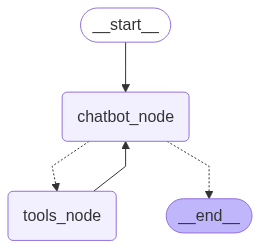

In [5]:
# Check the Graph Structure
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        webSearchAgent.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
    )
)

In [6]:
# Running the Agent Response
# Part 1 : Generate a new checkpoint ID
import uuid

config = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),  # Unique identifier for the conversation
    }
}

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Exiting the chat.")
        break

    response = await webSearchAgent.ainvoke(
        {"messages": [HumanMessage(content=user_input)]}, config=config
    )
    print("Me:", user_input)
    print("AI:", response["messages"][-1].content)

Exiting the chat.


In [ ]:
"""Note : Every Response is stored in helper-json """
# TODO: Confirm json of chat_model_stream and chat_model_end
from langchain_core.messages import HumanMessage

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Exiting the chat.")
        break

    print("", end="", flush=True)

    # Stream events from LangGraph
    """ ===> Fundamental Streaming Response"""
    # async for event in webSearchAgent.astream_events(
    #     {"messages": [HumanMessage(content=user_input)]},
    #     version="v2",
    #     config=config,
    # ):
    #     print(event)

    """ ====> Getting the content in streaming response - on_chain_stream"""
    async for event in webSearchAgent.astream_events(
        {"messages": [HumanMessage(content=user_input)]},
        version="v2",
        config=config,
    ):
        event_type = event.get("event")
        if event_type == "on_chain_stream":
            print(event)
            mssg = event["data"]["chunk"]
            print(mssg)
    
    """ =====> If chat model do some tools calls - on_chat_model_end"""
    # async for event in webSearchAgent.astream_events(
    #     {"messages": [HumanMessage(content=user_input)]},
    #     version="v2",
    #     config=config,
    # ):
    #     # print(event)
    #     event_type = event.get("event")
    #     if event_type == "on_chat_model_end":
    #         print(event)
    
    """ =====> Tavily Search Citations - on_tool_end"""
    # async for event in webSearchAgent.astream_events(
    #     {"messages": [HumanMessage(content=user_input)]},
    #     version="v2",
    #     config=config,
    # ):
    #     event_type = event.get("event")
    #     if event_type == "on_tool_end":
    #         print(event)

    

{'event': 'on_chain_stream', 'run_id': 'fcaf0e30-143a-4be8-9b95-b97d8fec84f3', 'name': 'chatbot_node', 'tags': ['graph:step:1'], 'metadata': {'thread_id': '155b1555-216c-4b91-8ec2-03177dae17b9', 'langgraph_step': 1, 'langgraph_node': 'chatbot_node', 'langgraph_triggers': ('branch:to:chatbot_node',), 'langgraph_path': ('__pregel_pull', 'chatbot_node'), 'langgraph_checkpoint_ns': 'chatbot_node:5721294a-7077-f34a-8ddd-d4f74b297160'}, 'data': {'chunk': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"topic": "finance", "query": "nvidia stock price"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-b209455c-85f1-4aaa-bcea-01ad2575ebd4', tool_calls=[{'name': 'tavily_search', 'args': {'topic': 'finance', 'query': 'nvidia stock price'}, 'id': 'b1cbc8b3-4a6c-40b0-8a84-0bdd48992a72', 'type': 'tool_call'}], usage_metadata={'input_tokens': 504, 'output_tokens': 10, 'tota